# Stable Diffusion quantization example

<b>Stable Diffusion (SD)</b> is a [Latent Diffusion Model (LDM)](https://arxiv.org/pdf/2112.10752), capable of generating images either conditionally (e.g., from text) or unconditionally.  

In this notebook, we will implement SD inference from scratch, and then apply <b> quantization </b> to reduce model's disk usage.

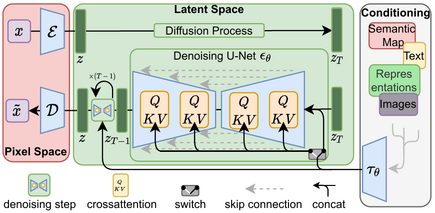

## 0. Install Dependencies

In [1]:
# !pip install -r requirements.txt

from diffusers import PNDMScheduler, StableDiffusionPipeline
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

from utils import visualize_grid, load_models
from inference import sd_inference

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "sd-legacy/stable-diffusion-v1-5"
prompt = "Big dog in a river"
num_inference_steps = 50
guidance_scale=7.5
num_images = 4

## 1. Original SD result

In [2]:
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
pipe.scheduler.set_timesteps(num_inference_steps)
images = pipe(
    prompt,
    guidance_scale=guidance_scale,
    num_images_per_prompt = num_images
)
images = images['images']
del pipe

C:\Users\karae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/50 [00:00<?, ?it/s]

This is how original SD pipeline result looks like:

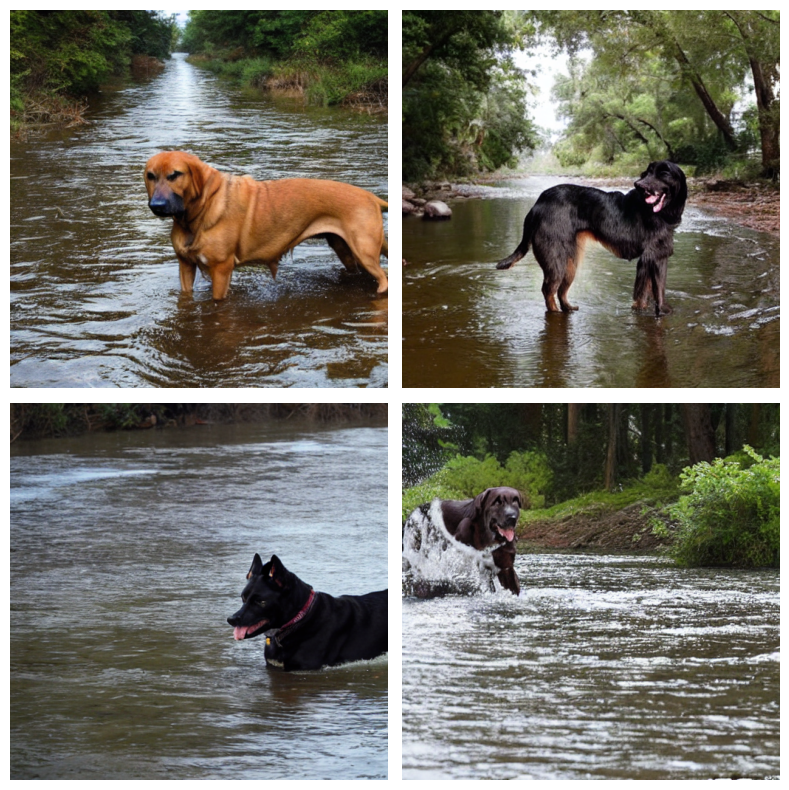

In [4]:
visualize_grid(images)

## 2. SD inference from scratch
First, we need to load main parts of Stable Diffusion:


🔹 CLIP Tokenizer + Text Encoder — Encodes text prompts into conditioning vectors  
🔹 U-Net — The denoiser: iteratively refines the latent image representation  
🔹 VAE Decoder — Projects the final latent representation back into pixel space (i.e., the actual image)  
🔹 DDIM Scheduler — Adapts step size and noise removal to reduce steps size (to 30-50)

In [5]:
no_quantization_params = load_models(model_id)
no_quantization_params['scheduler'].set_timesteps(num_inference_steps)
no_quantization_params["text_prompt"] = prompt
no_quantization_params["device"] = device
no_quantization_params["guidance_scale"] = guidance_scale
no_quantization_params["num_images"] = num_images

In [6]:
# Run inference
images_no_quant = sd_inference(**no_quantization_params)

100%|██████████| 51/51 [00:37<00:00,  1.36it/s]


This is an image we get without quantization

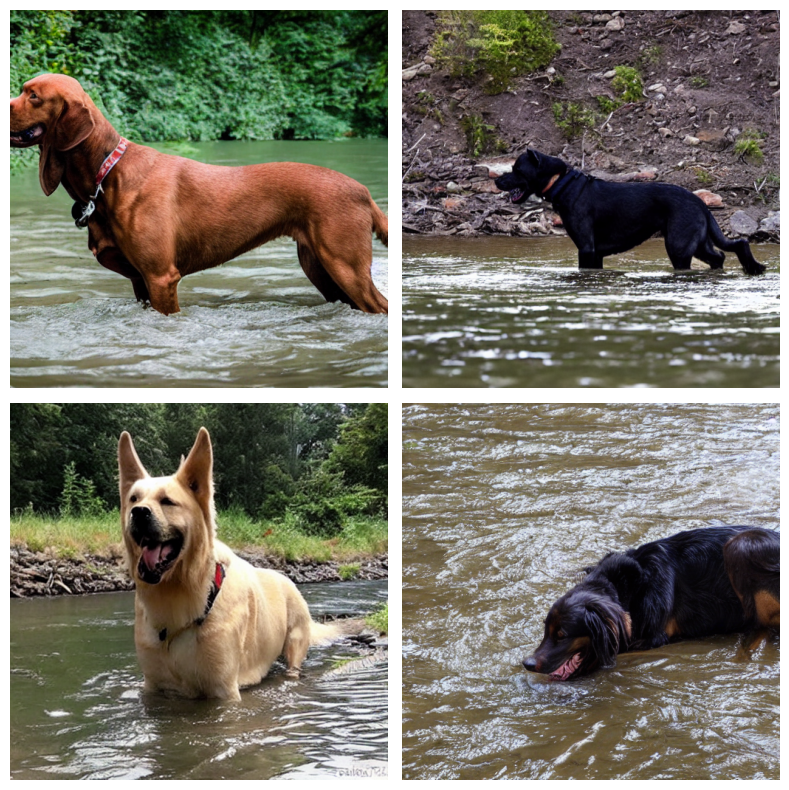

In [7]:
visualize_grid(images_no_quant)

In [8]:
del no_quantization_params

## 3. Quantization of  weights & quantized inference

<b>In this part we will convert weights to INT8 with linear and nonlinear quantization to reduce model weight </b>  

In [9]:
from quant import quantize_model, load_quantized_weights

In [10]:
def diffs(a,b):
    d=(a.float()-b.float()).abs()
    return dict(mae=d.mean().item(), rmse=(d.pow(2).mean().sqrt()).item(),
                max=d.max().item(), rel=(d/(a.abs()+1e-12)).mean().item())

def model_size_bytes(state_dict):
    s=0
    for t in state_dict.values():
        if isinstance(t, torch.Tensor):
            s += t.numel() * t.element_size()
        elif isinstance(t, dict):
            for t2 in t.values():
                if isinstance(t2, torch.Tensor):
                    s += t2.numel() * t2.element_size()
    return s

def qdq_model(model, key, qtype, dtype):
    sd0 = {n:p.detach().clone() for n,p in model.named_parameters()}
    pth = f"./weights/{key}_{qtype}_{dtype}.pth"

    size_before = model_size_bytes(sd0)

    quantize_model(model, qtype, dtype, save_path=pth)
    print(f"[{key}] ✔ Model quantized & saved -> {pth}")

    saved = torch.load(pth, map_location="cpu")
    size_after = model_size_bytes(saved['layers'])
    
    cnt_u8 = 0
    for n, t in saved['layers'].items():
        if 'q' in t and t['q'].dtype == torch.uint8:
            cnt_u8 += 1
        elif 'packed_q' in t and t['packed_q'].dtype == torch.uint8:
            cnt_u8 += 1
    assert cnt_u8 > 0, "No uint8 weights is stored!"
    print(f"[{key}] ✔ Found {cnt_u8} uint8 tensors in {pth}")

    load_quantized_weights(model, pth)
    print(f"[{key}] ✔ Model loaded from {pth}")
    
    assert size_before > size_after
    
    every_k_layers = 100
    print(f"[{key}] ✔ Model size decreased: {size_before/1e6:.2f} MB -> {size_after/1e6:.2f} MB\n")
    print(f"[{key}] ✔ Comparing outputs every {every_k_layers} layers")
    
    max_diff = 0.0; max_name = None
    for k, (n, p) in enumerate(model.named_parameters()):
        assert p.shape==sd0[n].shape, f"shape mismatch {n}"
        s = diffs(sd0[n], p)
        if s['max'] > max_diff: max_diff, max_name = s['max'], n
        if k % every_k_layers == 0:
            print(f"[{key}] COMPARING {n}: mae={s['mae']:.3e} rmse={s['rmse']:.3e} max={s['max']:.3e} rel={s['rel']:.3e}")
            print("...")
    print(f"[{key}] MAX DIFF: {max_diff:.6e} at {max_name}")
    return model

In [11]:
static_params = {
    "text_prompt": prompt,
    "device": device,
    "guidance_scale": guidance_scale,
    "num_images": num_images
}

### 3.1 Linear quantize, uint8

In [12]:
lq8_params = load_models(model_id)
lq8_params.update(static_params)
lq8_params['scheduler'].set_timesteps(num_inference_steps)

qtype = "linear"
dtype = "uint8"
models_to_quantize = ['text_encoder', 'unet', 'vae']
# models_to_quantize = ['unet']

In [13]:
for key in models_to_quantize:
    model = lq8_params[key]
    model = qdq_model(model, key, qtype, dtype)

[text_encoder] ✔ Model quantized & saved -> ./weights/text_encoder_linear_uint8.pth
[text_encoder] ✔ Found 99 uint8 tensors in ./weights/text_encoder_linear_uint8.pth


C:\Users\karae\AppData\Local\Temp\ipykernel_15680\1167881429.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(pth, map_location="cpu")
C:\Users\karae\

[text_encoder] ✔ Model loaded from ./weights/text_encoder_linear_uint8.pth
[text_encoder] ✔ Model size decreased: 492.24 MB -> 123.78 MB

[text_encoder] ✔ Comparing outputs every 100 layers
[text_encoder] COMPARING text_model.embeddings.token_embedding.weight: mae=1.132e-03 rmse=1.310e-03 max=2.274e-03 rel=2.596e-01
...
[text_encoder] COMPARING text_model.encoder.layers.6.self_attn.v_proj.weight: mae=9.136e-05 rmse=1.058e-04 max=2.467e-04 rel=3.246e-02
...
[text_encoder] MAX DIFF: 1.523259e+00 at text_model.encoder.layers.11.layer_norm2.weight
[unet] ✔ Model quantized & saved -> ./weights/unet_linear_uint8.pth
[unet] ✔ Found 391 uint8 tensors in ./weights/unet_linear_uint8.pth
[unet] ✔ Model loaded from ./weights/unet_linear_uint8.pth
[unet] ✔ Model size decreased: 3438.08 MB -> 862.14 MB

[unet] ✔ Comparing outputs every 100 layers
[unet] COMPARING conv_in.weight: mae=2.661e-04 rmse=3.230e-04 max=1.326e-03 rel=3.173e-02
...
[unet] COMPARING down_blocks.1.attentions.0.transformer_block

100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


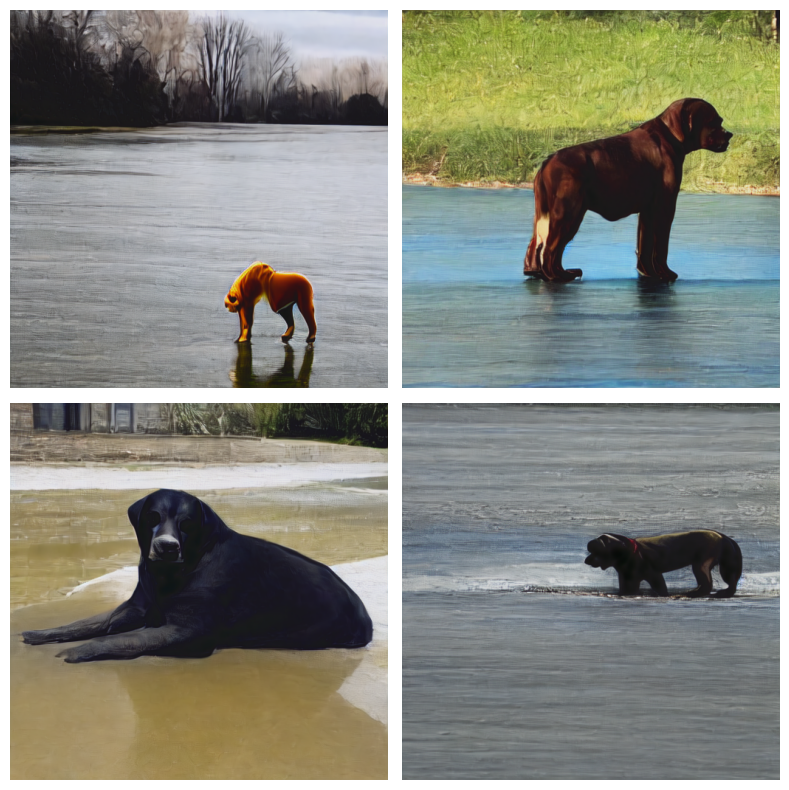

In [14]:
lq8_images = sd_inference(**lq8_params)
visualize_grid(lq8_images)
del lq8_params

### 3.2 Linear quantize, uint4

In [15]:
lq4_params = load_models(model_id)
lq4_params.update(static_params)
lq4_params['scheduler'].set_timesteps(num_inference_steps)

qtype = "linear"
dtype = "uint4"
models_to_quantize = ['text_encoder', 'unet', 'vae']
# models_to_quantize = ['unet']

In [16]:
for key in models_to_quantize:
    model = lq4_params[key]
    model = qdq_model(model, key, qtype, dtype)

[text_encoder] ✔ Model quantized & saved -> ./weights/text_encoder_linear_uint4.pth
[text_encoder] ✔ Found 99 uint8 tensors in ./weights/text_encoder_linear_uint4.pth


C:\Users\karae\AppData\Local\Temp\ipykernel_15680\1167881429.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(pth, map_location="cpu")


[text_encoder] ✔ Model loaded from ./weights/text_encoder_linear_uint4.pth
[text_encoder] ✔ Model size decreased: 492.24 MB -> 62.30 MB

[text_encoder] ✔ Comparing outputs every 100 layers
[text_encoder] COMPARING text_model.embeddings.token_embedding.weight: mae=1.103e-02 rmse=1.380e-02 max=3.865e-02 rel=9.989e-01
...
[text_encoder] COMPARING text_model.encoder.layers.6.self_attn.v_proj.weight: mae=1.550e-03 rmse=1.795e-03 max=4.185e-03 rel=3.105e-01
...
[text_encoder] MAX DIFF: 1.523259e+00 at text_model.encoder.layers.11.layer_norm2.weight
[unet] ✔ Model quantized & saved -> ./weights/unet_linear_uint4.pth
[unet] ✔ Found 391 uint8 tensors in ./weights/unet_linear_uint4.pth
[unet] ✔ Model loaded from ./weights/unet_linear_uint4.pth
[unet] ✔ Model size decreased: 3438.08 MB -> 432.57 MB

[unet] ✔ Comparing outputs every 100 layers
[unet] COMPARING conv_in.weight: mae=4.529e-03 rmse=5.527e-03 max=2.189e-02 rel=2.976e-01
...
[unet] COMPARING down_blocks.1.attentions.0.transformer_blocks

100%|██████████| 51/51 [00:41<00:00,  1.23it/s]


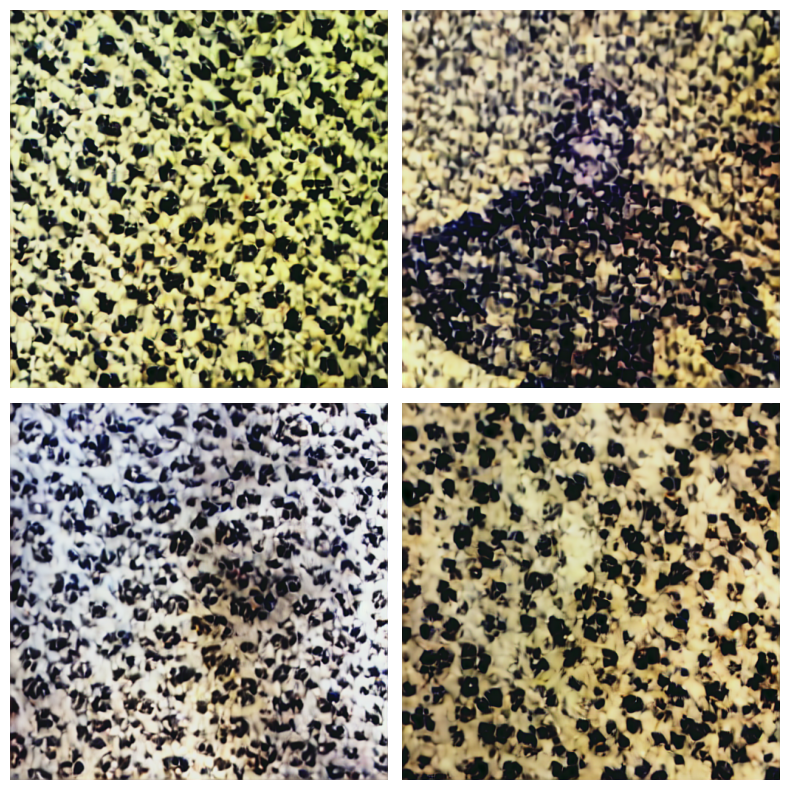

In [17]:
lq4_images = sd_inference(**lq4_params)
visualize_grid(lq4_images)
del lq4_params

### 3.3 Nonlinear quantize, uint8

In [18]:
nlq8_params = load_models(model_id)
nlq8_params.update(static_params)
nlq8_params['scheduler'].set_timesteps(num_inference_steps)

qtype = "nonlinear"
dtype = "uint8"
models_to_quantize = ['unet']

In [19]:
for key in models_to_quantize:
    model = nlq8_params[key]
    model = qdq_model(model, key, qtype, dtype)

[unet] ✔ Model quantized & saved -> ./weights/unet_nonlinear_uint8.pth


C:\Users\karae\AppData\Local\Temp\ipykernel_15680\1167881429.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(pth, map_location="cpu")


[unet] ✔ Found 391 uint8 tensors in ./weights/unet_nonlinear_uint8.pth
[unet] ✔ Model loaded from ./weights/unet_nonlinear_uint8.pth
[unet] ✔ Model size decreased: 3438.08 MB -> 969.54 MB

[unet] ✔ Comparing outputs every 100 layers
[unet] COMPARING conv_in.weight: mae=1.789e-03 rmse=5.233e-03 max=4.778e-02 rel=3.891e-01
...
[unet] COMPARING down_blocks.1.attentions.0.transformer_blocks.0.ff.net.0.proj.weight: mae=3.341e-04 rmse=4.943e-04 max=7.808e-03 rel=2.418e-02
...
[unet] COMPARING down_blocks.2.attentions.1.transformer_blocks.0.norm3.weight: mae=6.040e-04 rmse=2.514e-03 max=8.713e-02 rel=3.427e-03
...
[unet] COMPARING up_blocks.1.attentions.0.transformer_blocks.0.attn1.to_out.0.bias: mae=0.000e+00 rmse=0.000e+00 max=0.000e+00 rel=0.000e+00
...
[unet] COMPARING up_blocks.1.resnets.2.conv2.weight: mae=4.203e-04 rmse=6.290e-04 max=1.044e-02 rel=1.170e-02
...
[unet] COMPARING up_blocks.2.resnets.1.time_emb_proj.weight: mae=4.315e-05 rmse=7.858e-05 max=3.617e-03 rel=6.270e-02
...
[une

100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


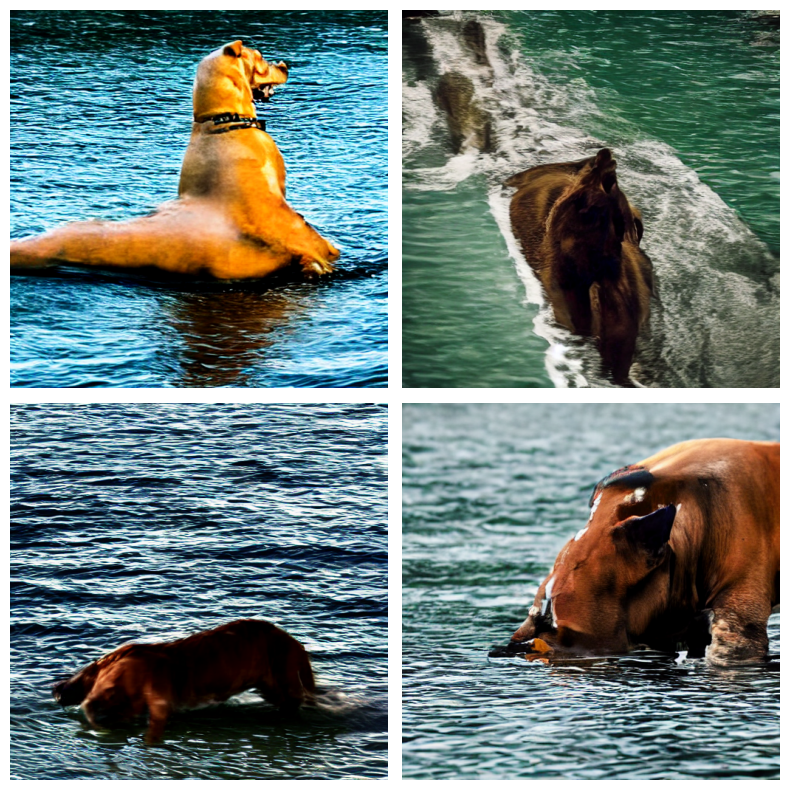

In [20]:
nlq8_images = sd_inference(**nlq8_params)
visualize_grid(nlq8_images)
del nlq8_params

### 3.4 Nonlinear quantize, uint4

In [21]:
nlq4_params = load_models(model_id)
nlq4_params.update(static_params)
nlq4_params['scheduler'].set_timesteps(num_inference_steps)

qtype = "nonlinear"
dtype = "uint4"
models_to_quantize = ['unet']

In [22]:
for key in models_to_quantize:
    model = nlq4_params[key]
    model = qdq_model(model, key, qtype, dtype)

[unet] ✔ Model quantized & saved -> ./weights/unet_nonlinear_uint4.pth
[unet] ✔ Found 391 uint8 tensors in ./weights/unet_nonlinear_uint4.pth


C:\Users\karae\AppData\Local\Temp\ipykernel_15680\1167881429.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load(pth, map_location="cpu")


[unet] ✔ Model loaded from ./weights/unet_nonlinear_uint4.pth
[unet] ✔ Model size decreased: 3438.08 MB -> 539.97 MB

[unet] ✔ Comparing outputs every 100 layers
[unet] COMPARING conv_in.weight: mae=5.137e-03 rmse=8.097e-03 max=7.133e-02 rel=4.584e-01
...
[unet] COMPARING down_blocks.1.attentions.0.transformer_blocks.0.ff.net.0.proj.weight: mae=5.649e-03 rmse=8.456e-03 max=1.227e-01 rel=1.500e-01
...
[unet] COMPARING down_blocks.2.attentions.1.transformer_blocks.0.norm3.weight: mae=1.380e-02 rmse=1.449e-02 max=8.713e-02 rel=5.105e-02
...
[unet] COMPARING up_blocks.1.attentions.0.transformer_blocks.0.attn1.to_out.0.bias: mae=0.000e+00 rmse=0.000e+00 max=0.000e+00 rel=0.000e+00
...
[unet] COMPARING up_blocks.1.resnets.2.conv2.weight: mae=7.233e-03 rmse=1.098e-02 max=2.087e-01 rel=1.936e-01
...
[unet] COMPARING up_blocks.2.resnets.1.time_emb_proj.weight: mae=7.112e-04 rmse=1.311e-03 max=5.696e-02 rel=2.160e-01
...
[unet] COMPARING up_blocks.3.resnets.0.norm1.weight: mae=2.081e-02 rmse=2.7

100%|██████████| 51/51 [00:37<00:00,  1.37it/s]


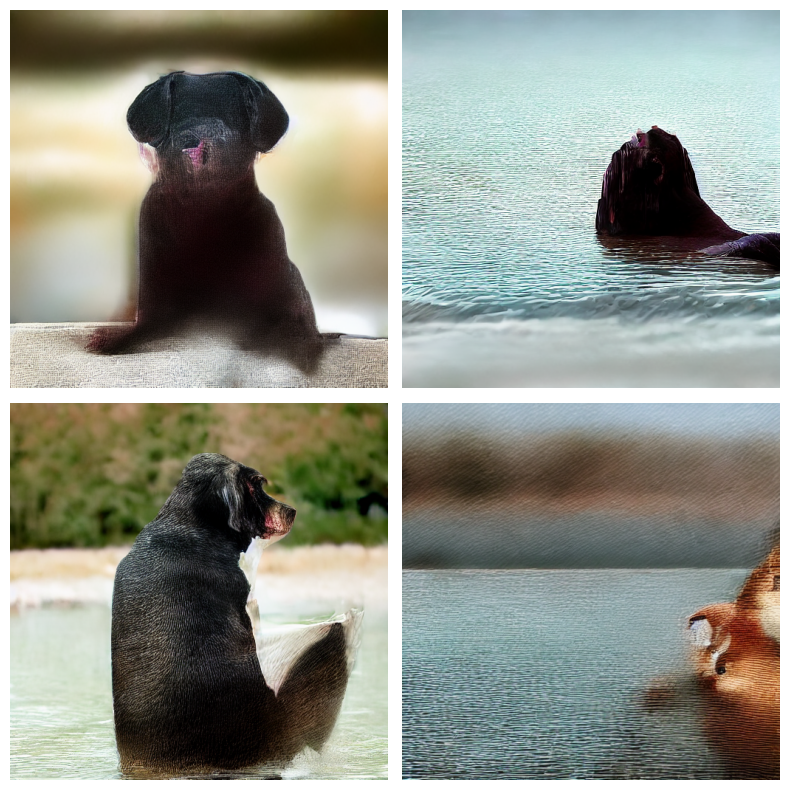

In [23]:
nlq4_images = sd_inference(**nlq4_params)
visualize_grid(nlq4_images)
del nlq4_params

In [24]:
# TODO:
# fix uint4 (обрезать квантили в тензоре)
# квант биас
# on-air